# Gibbs Sampling from errors-in model


### Setup

In [53]:
import numpy as np
import scipy.stats as stats
import matplotlib.pyplot as plt
from scipy.special import gammaln
import corner
from scipy.stats import invgamma
import seaborn as sns
from dataclasses import dataclass
from typing import Optional
import pymc as pm


In [56]:
N=100
@dataclass(frozen=True)
class Parameters:
    N: int
    # Chosen parameter values
    sigma_int_sqrd: float
    theta_0: float 
    theta_1: float
    x0: float 
    Rx: float # So Rx^2 = 1.0
    sigma_x_sqrd: float 
    sigma_y_sqrd: float

    # Hyperparameters for priors (not used in data generation)
    mu_x0: float
    sigma_x0_sqrd: float
    alpha_R: float
    beta_R: float
    alpha_sigma: float
    beta_sigma: float
    mu_theta: np.ndarray
    sigma_theta_squared: float 
    sigma_0_inv: float
    mu_0: float
    gamma: Optional[float] = None
    
def generate_latents(params: Parameters, n: int = None) -> tuple[np.ndarray]:
    if n is None:
        n = params.N
    x_true = np.random.normal(loc=params.x0, scale=params.Rx, size=n)
    mu_y = params.theta_0 + params.theta_1 * x_true
    y_true = np.random.normal(loc=mu_y, scale=np.sqrt(params.sigma_int_sqrd), size=n)
    return x_true, mu_y, y_true

def generate_obs(x_true: np.ndarray, y_true: np.ndarray, params: Parameters, n: int = None) -> tuple[np.ndarray]:
    if n is None:
        n = params.N
    x_obs = np.random.normal(loc=x_true, scale=np.sqrt(params.sigma_x_sqrd), size=n)
    y_obs = np.random.normal(loc=y_true, scale=np.sqrt(params.sigma_y_sqrd), size=n)
    return x_obs, y_obs

def true_relationship(x, theta_0, theta_1):
    return theta_0 + theta_1 * x

def plot_data(x_obs: np.ndarray, y_obs: np.ndarray, x_true: np.ndarray, y_true: np.ndarray,params) -> None:
    plt.figure(figsize=(8, 6))
    plt.errorbar(x_obs, y_obs, xerr=params.sigma_x_sqrd, yerr=np.sqrt(params.sigma_y_sqrd+params.sigma_int_sqrd), fmt='o', ecolor='gray', capsize=3, label='Observed data')
    plt.xlabel('x_obs')
    plt.ylabel('y_obs')
    plt.title('Synthetic Data Generated from Errors-in-Variables Model')
    plt.grid(True)
    plt.plot(x_true, y_true, label='True Relationship', color='red')
    plt.legend()
    plt.show()

def log_posterior_y(y, mu_y, sigma_y, gamma,logistic_term):
    """
    Computes the log of the posterior (up to a constant) for y:
        p(y) ∝ [1 / (1 + exp(-gamma*y))] * Normal(y; mu_y, sigma_y^2)
    """
    # Log of the logistic factor
    #  log( 1 / (1 + e^(-gamma * y)) ) = -log(1 + e^(-gamma * y))
    
    # Log of the Normal(y; mu_y, sigma_y^2)
    #  = -0.5 * log(2π σ_y^2) - (y - mu_y)^2 / (2 σ_y^2)
    # We can drop the -0.5 * log(2π σ_y^2) term if we only need proportionality
    # but including it can help with numeric stability.
    diff = y - mu_y
    normal_term = -0.5 * np.log(2.0 * np.pi * sigma_y**2) - 0.5 * (diff**2 / sigma_y**2)

    return logistic_term + normal_term

def metropolis_step(y, params, mu_y, sigma_y,logistic_term, step_size=0.1):
    """
    One Metropolis–Hastings update for y.
    Proposes y_new from a random-walk normal around current_y,
    then accepts/rejects based on the MH acceptance ratio.
    """
    # Propose a new y from Normal(current_y, step_size^2)
    y_proposal = np.random.normal(loc=y, scale=step_size)

    # Compute log posterior at current and proposed y
    logp_current = log_posterior_y(y, mu_y, sigma_y, params.gamma, logistic_term)
    logp_proposal = log_posterior_y(y_proposal, mu_y, sigma_y, params.gamma, logistic_term)

    # Compute acceptance probability
    # log-accept-ratio = logp_proposal - logp_current
    log_accept_ratio = logp_proposal - logp_current

    # Generate random uniform numbers and take log
    log_u = np.log(np.random.rand(len(y)))
        
    # Create a boolean mask for acceptance
    accept = log_u < log_accept_ratio

    # Create result array with accepted proposals and rejected originals
    result = np.copy(y)
    result[accept] = y_proposal[accept]

    return result

def sample_x_i_alt(vars, params):
    """
    Sample latent x for observed data points
    """
    x_i = vars["x_i"]
    y_i_obs = vars["y_obs"]
    x_i_obs = vars["x_obs"] 
    x_i_start = x_i.copy()
    N = vars.get("N_obs", vars["N"])
    for i in range(N):
        sigma_xi_sqrd = 1 / (vars["theta_1"]**2 / vars["sigma_int_sqrd"] + 1 / params.sigma_x_sqrd + 1 / vars["Rx2"])
        mu_xi = sigma_xi_sqrd * (
            vars["theta_1"] * (y_i_obs[i] - vars["theta_0"]) / vars["sigma_int_sqrd"] +
            x_i_obs[i] /  params.sigma_x_sqrd +
            vars["x0"] / vars["Rx2"]
        )
        x_i[i] = np.random.normal(mu_xi, np.sqrt(sigma_xi_sqrd))

    assert np.all(x_i_start[N:] == x_i[N:]), "Non-observed data points changed"
    
    return x_i[:N]

def sample_x_i(vars, params):
    """
    Sample latent x for observed data points
    """
    x_i = vars["x_i"]
    y_i = vars["y_i"] 
    x_i_start = x_i.copy()
    N = vars.get("N_obs", vars["N"])
    for i in range(N):
        sigma_xi_sqrd = 1 / (vars["theta_1"]**2 / vars["sigma_int_sqrd"] + 1 / params.sigma_x_sqrd + 1 / vars["Rx2"])
        mu_xi = sigma_xi_sqrd * (
            vars["theta_1"] * (y_i[i] - vars["theta_0"]) / vars["sigma_int_sqrd"] +
            vars["x_obs"][i] /  params.sigma_x_sqrd +
            vars["x0"] / vars["Rx2"]
        )
        x_i[i] = np.random.normal(mu_xi, np.sqrt(sigma_xi_sqrd))

    assert np.all(x_i_start[N:] == x_i[N:]), "Non-observed data points changed"
    
    return x_i[:N]

def sample_x_j(vars, params):
    """
    Sample latent x for non-observed data points
    """
    x_j = vars["x_i"]
    x_j_start = x_j.copy() 
    for j in range(vars["N_obs"], vars["N"]):
        sigma_x_sqrd = 1 / (vars["theta_1"]**2 / vars["sigma_int_sqrd"] + 1 / params.sigma_x_sqrd + 1 / vars["Rx2"])
        mu_xi = sigma_x_sqrd * (
            vars["theta_1"] * (vars["y_i"][j] - vars["theta_0"]) / vars["sigma_int_sqrd"] +
            vars["x0"] / vars["Rx2"]
        )
        x_j[j] = np.random.normal(mu_xi, np.sqrt(sigma_x_sqrd))
    
    assert np.all(x_j_start[:vars["N_obs"]] == x_j[:vars["N_obs"]]), "Observed data points changed"
    
    return x_j[vars["N_obs"]:]


# def sample_y_i(vars, params, y_obs):
#     sigma_yi_sqrd = np.sqrt(1/(1/vars["sigma_int_sqrd"] + 1/params.sigma_y_sqrd))
#     mu_yi = (sigma_yi_sqrd**2)*(
#         y_obs/params.sigma_y_sqrd 
#         + (vars["theta_0"]
#             + vars["theta_1"]*vars["x_i"])
#             / vars["sigma_int_sqrd"])
#     y_i = np.random.normal(mu_yi, sigma_yi_sqrd)
#     return y_i
def sample_y_i(vars, params):
    """
    Sample latent y for observed data points with selection function, using MH step.
    """
    N = vars.get("N_obs", vars["N"])
    y_i = vars["y_i"][:N]
    
    sigma_yi = np.sqrt(1/(1/vars["sigma_int_sqrd"] + 1/params.sigma_y_sqrd))
    mu_yi = (vars["y_obs"]/params.sigma_y_sqrd 
             + (vars["theta_0"] 
             + vars["theta_1"]*vars["x_i"][:N])
             / vars["sigma_int_sqrd"])*sigma_yi**2
    # logistic_term = -np.log(1.0 + np.exp(-params.gamma * y_i))
    # y_i = metropolis_step(y_i, params, mu_yi, sigma_yi, logistic_term)
    y_i = np.random.normal(mu_yi, sigma_yi)
    assert np.all(vars["y_i"][N:] == vars["y_i"][N:]), "Non-observed data points changed"
    return y_i
def sample_y_j(vars, params):
    """
    Sample latent y for observed data points with selection function, using MH step.
    """
    N = vars["N_obs"]
    y_j = vars["y_i"][N:]
    
    sigma_yi = np.sqrt(1/(1/vars["sigma_int_sqrd"] + 1/params.sigma_y_sqrd))
    mu_yi = (vars["y_miss"]/params.sigma_y_sqrd 
             + (vars["theta_0"] 
             + vars["theta_1"]*vars["x_i"][N:])
             / vars["sigma_int_sqrd"])*sigma_yi**2
    # logistic_term = -np.log(1.0 + np.exp(-params.gamma * y_i))
    # y_i = metropolis_step(y_i, params, mu_yi, sigma_yi, logistic_term)
    y_j = np.random.normal(mu_yi, sigma_yi)
    assert np.all(vars["y_i"][:N] == vars["y_i"][:N]), "Non-observed data points changed"
    return y_j
# def sample_y_i_w_selection(vars, params, y_obs):
#     """
#     Sample latent y for observed data points with selection function, using MH step.
#     """
#     N = vars["N_obs"]
#     y_i = vars["y_i"][:N]
    
#     sigma_yi = np.sqrt(1/(1/vars["sigma_int_sqrd"] + 1/params.sigma_y_sqrd))
#     mu_yi = (y_obs/params.sigma_y_sqrd 
#              + (vars["theta_0"] 
#              + vars["theta_1"]*vars["x_i"][:N])
#              / vars["sigma_int_sqrd"])*sigma_yi**2
#     logistic_term = -np.log(1.0 + np.exp(-params.gamma * y_i))
#     y_i = metropolis_step(y_i, params, mu_yi, sigma_yi, logistic_term)
#     assert np.all(vars["y_i"][N:] == vars["y_i"][N:]), "Non-observed data points changed"
#     return y_i

# def sample_y_j(vars, params: Parameters):
#     """
#     Sample latent y for non-observed data points with selection function with MH step.
#     """
#     N_obs = vars["N_obs"]
#     y_j = vars["y_i"][N_obs:]
#     # mu_yi = vars["theta_0"] + vars["theta_1"]*vars["x_i"][N_obs:]
#     # logistic_term = np.log(np.exp(-params.gamma * y_j))-np.log(1.0 + np.exp(-params.gamma * y_j[:N_obs]))
#     # y_j = metropolis_step(y_j, params, mu_yi, np.sqrt(vars["sigma_int_sqrd"]), logistic_term)
#     # assert np.all(vars["y_i"][:N_obs] == vars["y_i"][:N_obs]), "Observed data points changed"
#     sigma_yj = np.sqrt(1/(1/vars["sigma_int_sqrd"] + 1/params.sigma_y_sqrd))
#     mu_yj = (vars["y_miss"]/params.sigma_y_sqrd 
#              + (vars["theta_0"] 
#              + vars["theta_1"]*vars["x_i"][N_obs:])
#              / vars["sigma_int_sqrd"])*sigma_yj**2
#     logistic_term = np.log(np.exp(-params.gamma * y_j))-np.log(1.0 + np.exp(-params.gamma * y_j[:N_obs]))
#     y_j = metropolis_step(y_j, params, mu_yj, sigma_yj, logistic_term)
#     return y_j
def sample_y_miss(vars, params):
    """
    Sample latent y for missing data points
    """
    N_obs = vars["N_obs"]
    y_j = vars["y_i"][N_obs:]
    y_miss = vars["y_miss"]
    logistic_term = np.log(np.exp(-params.gamma * vars["y_miss"])) \
                    - np.log(1.0 + np.exp(-params.gamma * vars["y_miss"]))
    y_miss = metropolis_step(y_miss, params, y_j, params.sigma_y_sqrd, logistic_term)
    return y_miss
    
def sample_theta(vars, params):
    X = np.vstack((np.ones(params.N), vars["x_i"])).T
    y = vars["y_i"]
    sigma_theta_inv = (X.T @ X) / vars["sigma_int_sqrd"] + params.sigma_0_inv
    sigma_theta = np.linalg.inv(sigma_theta_inv)
    mu_theta_post = sigma_theta @ (X.T @ y /vars["sigma_int_sqrd"] + params.sigma_0_inv @ params.mu_0)
    theta_sample = np.random.multivariate_normal(mu_theta_post, sigma_theta)
    return theta_sample

def sample_theta_from_obs(vars, params):
    X = np.vstack((np.ones(params.N), vars["x_i"])).T
    y = vars["y_obs"]
    sigma_theta_inv = (X.T @ X) / (vars["sigma_int_sqrd"] + params.sigma_y_sqrd) + params.sigma_0_inv
    sigma_theta = np.linalg.inv(sigma_theta_inv)
    mu_theta_post = sigma_theta @ (X.T @ y /(vars["sigma_int_sqrd"] + params.sigma_y_sqrd) + params.sigma_0_inv @ params.mu_0)
    theta_sample = np.random.multivariate_normal(mu_theta_post, sigma_theta)
    return theta_sample

def sample_x0(vars, params):
    sigma_x0_squared_post = 1 / (params.N / vars["Rx2"] + 1 / params.sigma_x0_sqrd)
    mu_x0_post = sigma_x0_squared_post * (np.sum(vars["x_i"]) / vars["Rx2"] + params.mu_x0 / params.sigma_x0_sqrd)
    x0 = np.random.normal(mu_x0_post, np.sqrt(sigma_x0_squared_post))
    return x0

def sample_Rx2(vars, params):
    alpha_R_post = params.alpha_R + params.N / 2
    beta_R_post = params.beta_R + 0.5 * np.sum((vars["x_i"] - vars["x0"])**2)
    Rx2 = invgamma.rvs(a=alpha_R_post, scale=beta_R_post)
    return Rx2

def sample_sigma_int_sqrd(vars, params):
    alpha_sigma_int_sqrd_sqrd_post = params.alpha_sigma + params.N / 2
    beta_sigma_int_sqrd_sqrd_post = params.beta_sigma + 0.5 * np.sum((vars["y_i"] - vars["theta_0"] - vars["theta_1"] * vars["x_i"])**2)
    sigma_int_sqrd_sqrd_x2 = invgamma.rvs(a=alpha_sigma_int_sqrd_sqrd_post, scale=beta_sigma_int_sqrd_sqrd_post)
    return sigma_int_sqrd_sqrd_x2

def init_arrays(num_iterations,params):
    theta_0_samples = np.zeros(num_iterations)
    theta_1_samples = np.zeros(num_iterations)
    x0_samples = np.zeros(num_iterations)
    Rx2_samples = np.zeros(num_iterations)
    x_i_samples = np.zeros((num_iterations, params.N))
    sigma_int_sqrd_samples = np.zeros(num_iterations)
    return {
        "theta_0": theta_0_samples,
        "theta_1": theta_1_samples, 
        "x0": x0_samples,
        "Rx2": Rx2_samples,
        "x_i": x_i_samples,
        "sigma_int_sqrd": sigma_int_sqrd_samples}
def corner_plot(samples, params):
    plot_samples = np.vstack([samples["theta_0"], samples["theta_1"], samples["x0"], samples["Rx"], samples["sigma_int"]]).T
    labels = [r"$\theta_0$", r"$\theta_1$", r"$x0$", r"$R_x$", r"$\sigma_{int}$"]
    truths = [params.theta_0, params.theta_1, params.x0, np.sqrt(params.Rx), np.sqrt(params.sigma_int_sqrd)]

    figure = corner.corner(
        plot_samples,
        labels=labels,
        truths=truths,
        show_titles=True,
        quantiles=[0.16, 0.5, 0.84],
        title_fmt=".2f",
        title_kwargs={"fontsize": 12}
    )

    plt.show()

def plot_marginal(samples, x_true):
    indices = [23, 67, 43]
    x_i_samples_selected = samples["x_i"][:, indices]
    x_i_true_selected = x_true[indices]

    num_selected = len(indices)
    fig, axes = plt.subplots(1, num_selected, figsize=(5 * num_selected, 4))

    for i, idx in enumerate(indices):
        ax = axes[i] if num_selected > 1 else axes
        sns.histplot(x_i_samples_selected[:, i], bins=50, kde=True, ax=ax, color='blue')
        ax.set_xlabel(f"$x {idx}$")
        ax.set_ylabel("Density")
        ax.set_title(f"Posterior of $x {idx}$")
        ax.axvline(x_i_true_selected[i], color='red', linestyle='--', label='True value')
        ax.legend()

    plt.tight_layout()
    plt.show()


## Intrinsic Dispersion

In [57]:
mu_theta= 0.0
sigma_theta_squared= 4.0 ** 2
sigma_0_inv= np.linalg.inv(np.diag([sigma_theta_squared, sigma_theta_squared]))
mu_0 = np.array([mu_theta, mu_theta])
params = Parameters( 
        N = 100,
        sigma_int_sqrd = 0.25,
        theta_0 = 1.0,
        theta_1 = 0.5,
        x0 = 0,
        Rx = 1,    # So Rx^2 = 1.0
        sigma_x_sqrd = 1,
        sigma_y_sqrd = 0.25,
        # Hyperparameters for priors (not used in data generation)
        mu_x0 = 1.0,
        sigma_x0_sqrd = 1.0,
        alpha_R = 0.1,
        beta_R = 1,
        alpha_sigma = 0.1,
        beta_sigma = 1,
        mu_theta= 0.0,
        sigma_theta_squared= 4.0 ** 2,
        sigma_0_inv=sigma_0_inv,
        mu_0=mu_0
        )
# Set random seed for reproducibility
np.random.seed(42)

x_true, mu_y, y_true = generate_latents(params,100)
# x_obs, y_obs = generate_obs(x_true, y_true, params,100)
x_obs = np.random.normal(loc=x_true, scale=np.sqrt(params.sigma_x_sqrd), size=params.N)
y_obs = np.random.normal(loc=mu_y, scale=np.sqrt(params.sigma_y_sqrd+ params.sigma_int_sqrd), size=params.N)
# Plot the generated data
y_true_wo_int_dip = true_relationship(x_true, params.theta_0, params.theta_1)

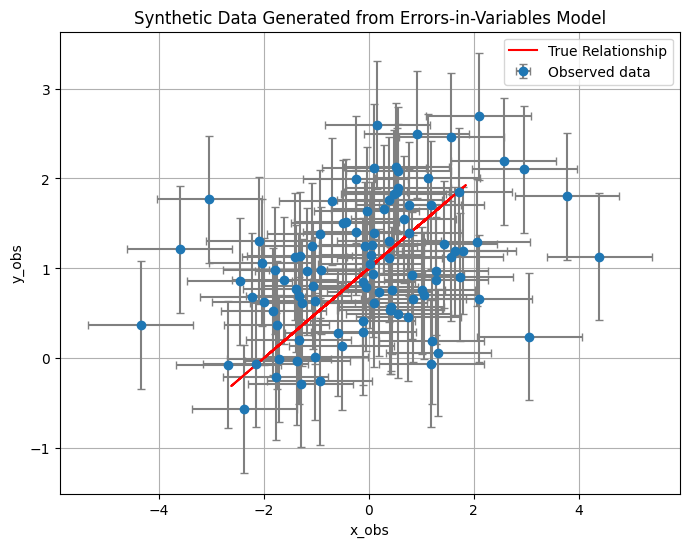

In [42]:
plot_data(
    x_obs=x_obs,
    y_obs=y_obs,
    x_true=x_true,
    y_true=y_true_wo_int_dip,
    params=params
    )

In [58]:
# Number of iterations for Gibbs sampler
num_iterations = 20000

samples = init_arrays(num_iterations, params)
# Initial values

vars = {
    "theta_0": 0.0,
    "theta_1": 0.0,
    "x0": np.mean(x_obs),
    "Rx2": np.var(x_obs),
    "x_i": x_obs.copy(),
    "y_i": y_obs.copy(),
    "sigma_int_sqrd": np.std(y_obs)/2,
    "N": params.N,
    "x_obs": x_obs,
    "y_obs": y_obs,
}   

# Start Gibbs sampling
for t in range(num_iterations):
    # Step 1: Sample x_i
    vars["x_i"] = sample_x_i_alt(vars, params)
    # vars["y_i"] = np.random.normal(loc=vars["theta_0"] + vars["theta_1"] * vars["x_i"], scale=np.sqrt(vars["sigma_int_sqrd"]))
    # Step 3: Sample theta_0 and theta_1 jointly
    vars["theta_0"], vars["theta_1"] = sample_theta(vars, params)
    # print("theta",vars["theta_0"], vars["theta_1"])
    # Step 4: Sample x0
    vars["x0"] = sample_x0(vars, params)
    # Step 5: Sample Rx^2
    vars["Rx2"] = sample_Rx2(vars, params)
    #print("Rx2",vars["Rx2"])
    # Step 6: Sample sigma_int_sqrd
    vars["sigma_int_sqrd"] = sample_sigma_int_sqrd(vars, params)
    
    for key in samples.keys():
        samples[key][t] = vars[key]
    
    if t % 500 == 0:
        print(f"Iteration {t} completed.")

# Convert Rx^2 samples to Rx samples
Rx_samples = np.sqrt(samples["Rx2"])
samples["Rx"] = Rx_samples
# Convert sigma_int_sqrd_sqrd^2 samples to sigma_int_sqrd_sqrd samples
sigma_int_sqrd_samples = np.sqrt(samples["sigma_int_sqrd"])
samples["sigma_int"] = sigma_int_sqrd_samples

# Discard burn-in samples
burn_in = 1000
for key in samples:
    samples[key] = samples[key][burn_in:]


Iteration 0 completed.
Iteration 500 completed.
Iteration 1000 completed.
Iteration 1500 completed.
Iteration 2000 completed.
Iteration 2500 completed.
Iteration 3000 completed.
Iteration 3500 completed.
Iteration 4000 completed.
Iteration 4500 completed.
Iteration 5000 completed.
Iteration 5500 completed.
Iteration 6000 completed.
Iteration 6500 completed.
Iteration 7000 completed.
Iteration 7500 completed.
Iteration 8000 completed.
Iteration 8500 completed.
Iteration 9000 completed.
Iteration 9500 completed.
Iteration 10000 completed.
Iteration 10500 completed.
Iteration 11000 completed.
Iteration 11500 completed.
Iteration 12000 completed.
Iteration 12500 completed.
Iteration 13000 completed.
Iteration 13500 completed.
Iteration 14000 completed.
Iteration 14500 completed.
Iteration 15000 completed.
Iteration 15500 completed.
Iteration 16000 completed.
Iteration 16500 completed.
Iteration 17000 completed.
Iteration 17500 completed.
Iteration 18000 completed.
Iteration 18500 completed

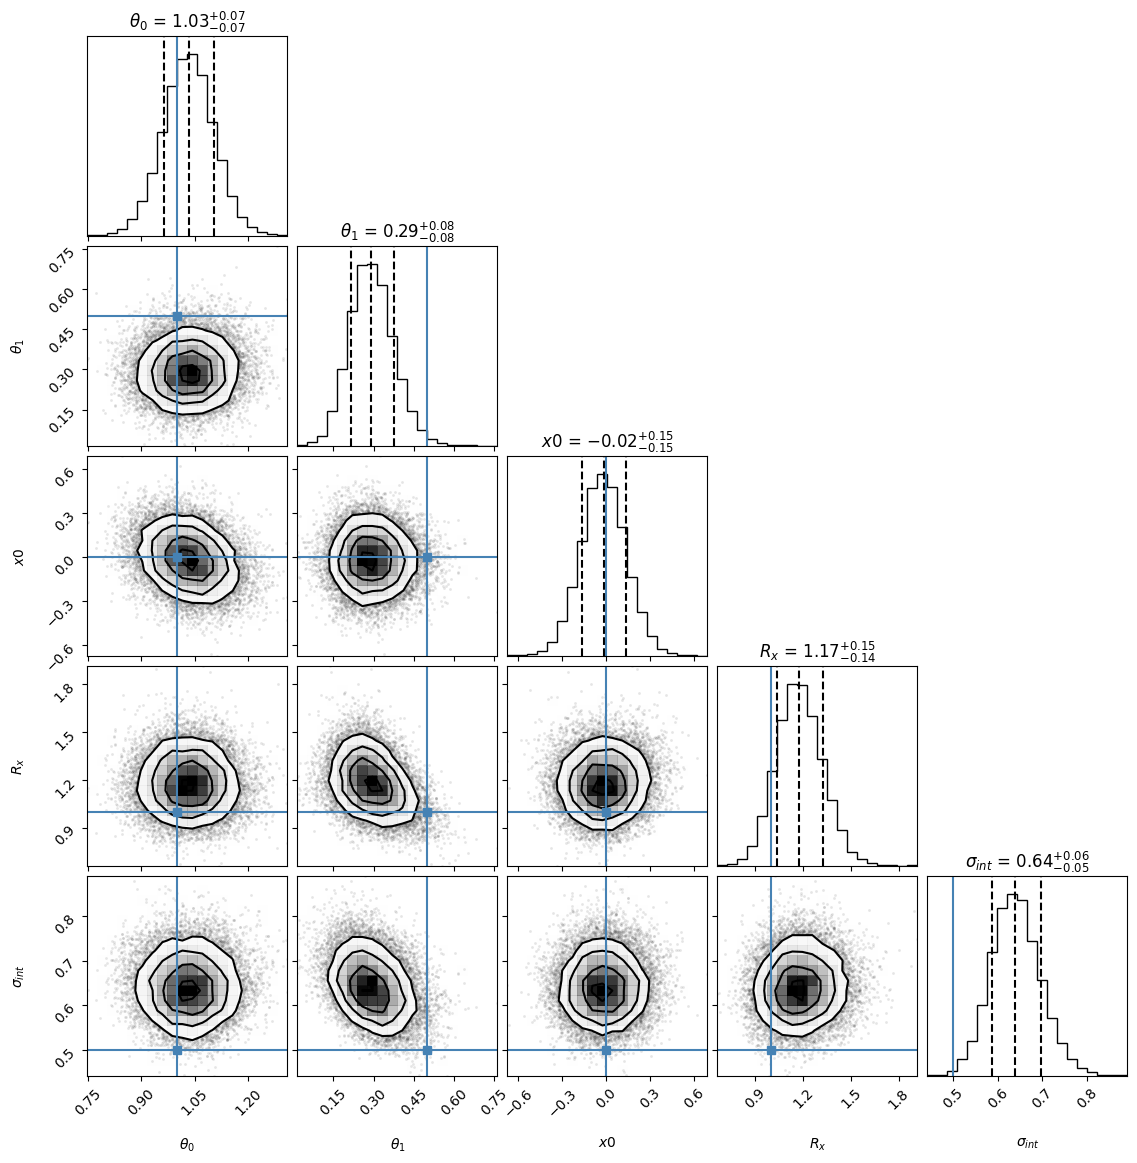

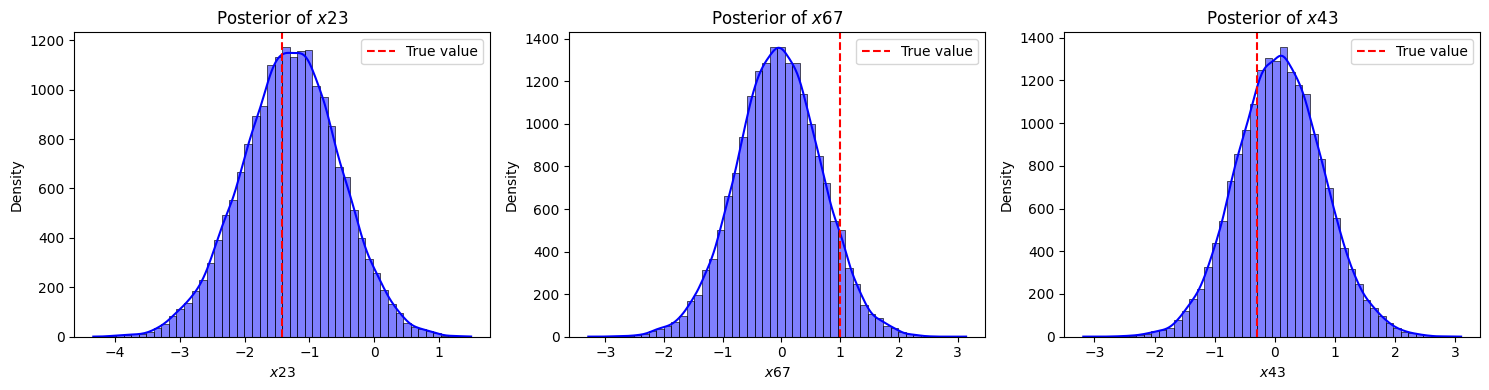

In [59]:
corner_plot(samples, params)
plot_marginal(samples, x_true)

## Intrinsic dispersion with sampling of latent y

$$
y_i \mid y_i^{\mathrm{obs}},\,\theta_0,\theta_1,\,x_i,\,\sigma_y,\,\sigma_{\text{int}}
\sim \mathcal{N}\Bigl(\mu_{y_i},\,\sigma_{y_i}^2\Bigr),
$$
with
$$
\mu_{y_i} = \left(\frac{1}{\sigma_y^2} + \frac{1}{\sigma_{\text{int}}^2}\right)^{-1} \left(\frac{y_i^{\mathrm{obs}}}{\sigma_y^2} + \frac{\theta_0+\theta_1\,x_i}{\sigma_{\text{int}}^2}\right)
$$
and
$$
\sigma_{y_i}^2 = \left(\frac{1}{\sigma_y^2} + \frac{1}{\sigma_{\text{int}}^2}\right)^{-1}.
$$


In [45]:
mu_theta= 0.0
sigma_theta_squared= 4.0 ** 2
sigma_0_inv= np.linalg.inv(np.diag([sigma_theta_squared, sigma_theta_squared]))
mu_0 = np.array([mu_theta, mu_theta])
params = Parameters( 
        N = 100,
        sigma_int_sqrd = 0.25,
        theta_0 = 1.0,
        theta_1 = 0.5,
        x0 = 0,
        Rx = 1,    # So Rx^2 = 1.0
        sigma_x_sqrd = 1,
        sigma_y_sqrd = 0.25,
        # Hyperparameters for priors (not used in data generation)
        mu_x0 = 1.0,
        sigma_x0_sqrd = 1.0,
        alpha_R = 0.1,
        beta_R = 1,
        alpha_sigma = 0.1,
        beta_sigma = 1,
        mu_theta= 0.0,
        sigma_theta_squared= 4.0 ** 2,
        sigma_0_inv=sigma_0_inv,
        mu_0=mu_0
        )
# Set random seed for reproducibility
np.random.seed(42)

x_true, mu_y, y_true = generate_latents(params,100)
# x_obs, y_obs = generate_obs(x_true, y_true, params,100)
x_obs = np.random.normal(loc=x_true, scale=np.sqrt(params.sigma_x_sqrd), size=params.N)
y_obs = np.random.normal(loc=mu_y, scale=np.sqrt(params.sigma_y_sqrd+ params.sigma_int_sqrd), size=params.N)
# Plot the generated data
y_true_wo_int_dip = true_relationship(x_true, params.theta_0, params.theta_1)

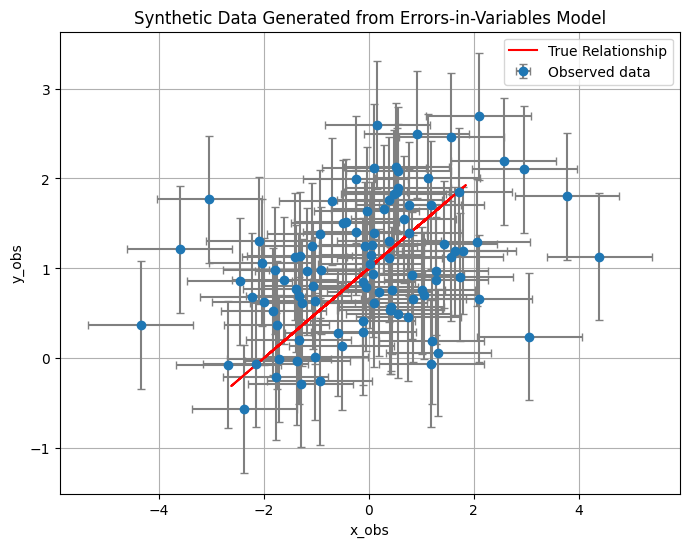

In [46]:
plot_data(
    x_obs=x_obs,
    y_obs=y_obs,
    x_true=x_true,
    y_true=y_true_wo_int_dip,
    params=params
    )

In [47]:
# Number of iterations for Gibbs sampler
num_iterations = 20000

samples = init_arrays(num_iterations, params)
# Initial values

vars = {
    "theta_0": 0.0,
    "theta_1": 0.0,
    "x0": np.mean(x_obs),
    "Rx2": np.var(x_obs),
    "x_i": x_obs.copy(),
    "y_i": y_obs.copy(),
    "sigma_int_sqrd": np.std(y_obs)/2,
    "N": params.N,
    "x_obs": x_obs,
    "y_obs": y_obs
}

# Start Gibbs sampling
for t in range(num_iterations):
    # Step 1: Sample x_i
    vars["x_i"] = sample_x_i(vars, params)
    # Step 2: Sample y_i
    vars["y_i"] = sample_y_i(vars, params)
    # Step 3: Sample theta_0 and theta_1 jointly
    vars["theta_0"], vars["theta_1"] = sample_theta(vars, params)
    # print("theta",vars["theta_0"], vars["theta_1"])
    # Step 4: Sample x0
    vars["x0"] = sample_x0(vars, params)
    # Step 5: Sample Rx^2
    vars["Rx2"] = sample_Rx2(vars, params)
    #print("Rx2",vars["Rx2"])
    # Step 6: Sample sigma_int_sqrd
    vars["sigma_int_sqrd"] = sample_sigma_int_sqrd(vars, params)
    
    for key in samples.keys():
        samples[key][t] = vars[key]
    
    if t % 500 == 0:
        print(f"Iteration {t} completed.")

# Convert Rx^2 samples to Rx samples
Rx_samples = np.sqrt(samples["Rx2"])
samples["Rx"] = Rx_samples
# Convert sigma_int_sqrd_sqrd^2 samples to sigma_int_sqrd_sqrd samples
sigma_int_sqrd_samples = np.sqrt(samples["sigma_int_sqrd"])
samples["sigma_int"] = sigma_int_sqrd_samples

# Discard burn-in samples
burn_in = 1000
for key in samples:
    samples[key] = samples[key][burn_in:]


Iteration 0 completed.
Iteration 500 completed.
Iteration 1000 completed.
Iteration 1500 completed.
Iteration 2000 completed.
Iteration 2500 completed.
Iteration 3000 completed.
Iteration 3500 completed.
Iteration 4000 completed.
Iteration 4500 completed.
Iteration 5000 completed.
Iteration 5500 completed.
Iteration 6000 completed.
Iteration 6500 completed.
Iteration 7000 completed.
Iteration 7500 completed.
Iteration 8000 completed.
Iteration 8500 completed.
Iteration 9000 completed.
Iteration 9500 completed.
Iteration 10000 completed.
Iteration 10500 completed.
Iteration 11000 completed.
Iteration 11500 completed.
Iteration 12000 completed.
Iteration 12500 completed.
Iteration 13000 completed.
Iteration 13500 completed.
Iteration 14000 completed.
Iteration 14500 completed.
Iteration 15000 completed.
Iteration 15500 completed.
Iteration 16000 completed.
Iteration 16500 completed.
Iteration 17000 completed.
Iteration 17500 completed.
Iteration 18000 completed.
Iteration 18500 completed

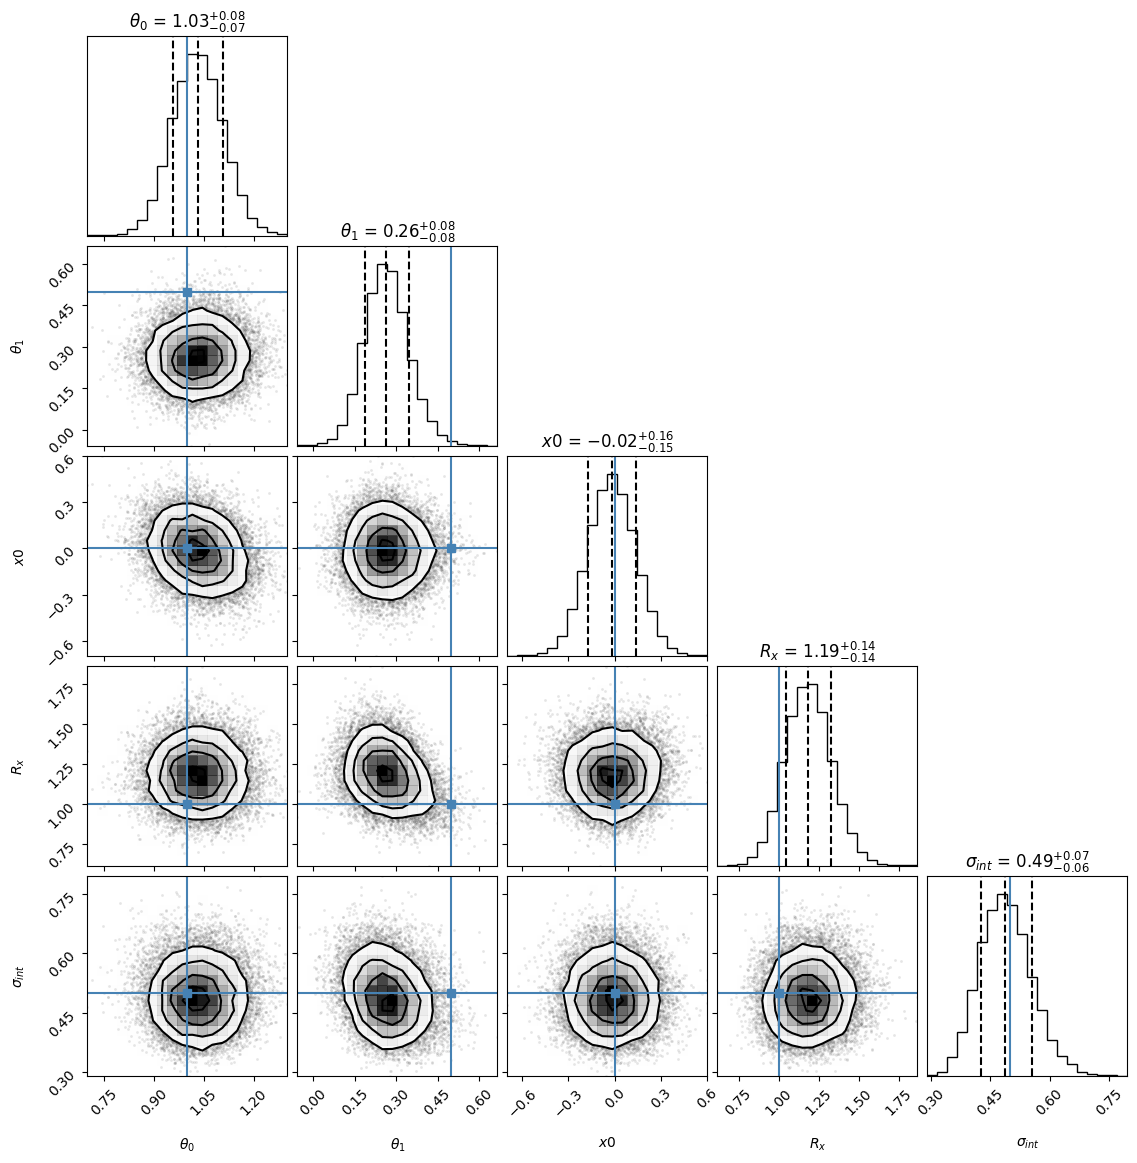

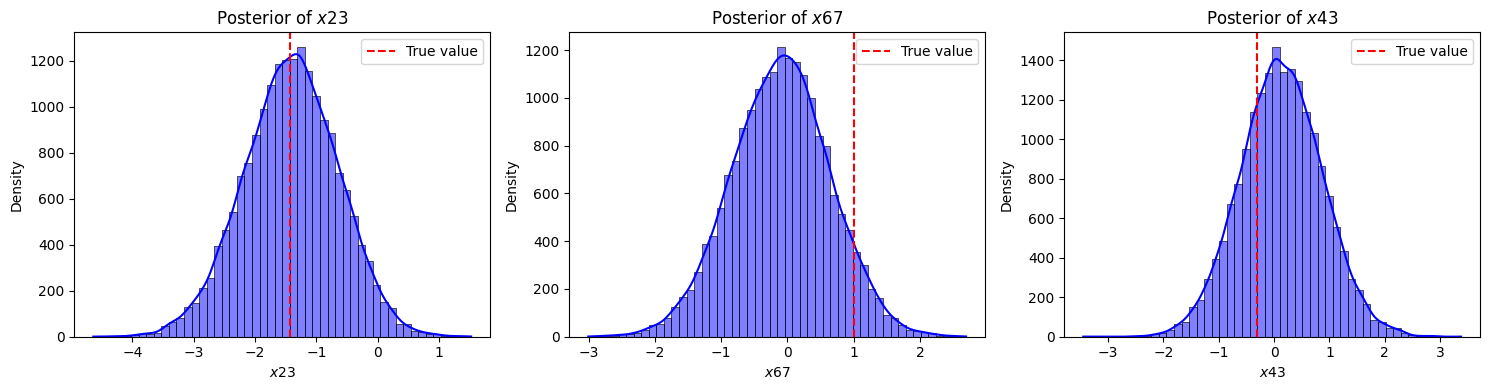

In [48]:
corner_plot(samples, params)
plot_marginal(samples, x_true)


## Model with intrinsic dispersion and selection function

In [60]:
mu_theta= 0.0
sigma_theta_squared= 4.0 ** 2
sigma_0_inv= np.linalg.inv(np.diag([sigma_theta_squared, sigma_theta_squared]))
mu_0 = np.array([mu_theta, mu_theta])
params = Parameters( 
        N = 200,
        sigma_int_sqrd = 0.25,
        theta_0 = 1.0,
        theta_1 = 0.5,
        x0 = 0,
        Rx = 1,    
        sigma_x_sqrd = 1,
        sigma_y_sqrd = 0.25,
        mu_x0 = 1.0,
        sigma_x0_sqrd = 1.0,
        alpha_R = 0.1,
        beta_R = 1,
        alpha_sigma = 0.1,
        beta_sigma = 1,
        mu_theta= 0.0,
        sigma_theta_squared= 4.0 ** 2,
        sigma_0_inv=sigma_0_inv,
        mu_0=mu_0,
        gamma=0.5
        )
# Set random seed for reproducibility
np.random.seed(42)

x_true, mu_y, y_true = generate_latents(params)
selected_indices = np.random.binomial(1, 1 / (1 + np.exp(-params.gamma * y_true)), params.N)

N_obs = np.sum(selected_indices)
# Reorder arrays based on selection
x_true_ordered = np.zeros_like(x_true)
y_true_ordered = np.zeros_like(y_true)
mu_y_ordered = np.zeros_like(mu_y)

# Copy selected indices first
x_true_ordered[:N_obs] = x_true[selected_indices == 1]
y_true_ordered[:N_obs] = y_true[selected_indices == 1]
mu_y_ordered[:N_obs] = mu_y[selected_indices == 1]

# Copy non-selected indices after
x_true_ordered[N_obs:] = x_true[selected_indices == 0]
y_true_ordered[N_obs:] = y_true[selected_indices == 0]
mu_y_ordered[N_obs:] = mu_y[selected_indices == 0]

# Replace original arrays with ordered versions
x_true = x_true_ordered
y_true = y_true_ordered
mu_y = mu_y_ordered

x_obs, y_obs = generate_obs(x_true[:N_obs], y_true[:N_obs], params, n=N_obs)
x_miss, y_miss = generate_obs(x_true[N_obs:], y_true[N_obs:], params, n=(params.N - N_obs))

# Plot the generated data
y_true_wo_int_dip = true_relationship(x_true, params.theta_0, params.theta_1)

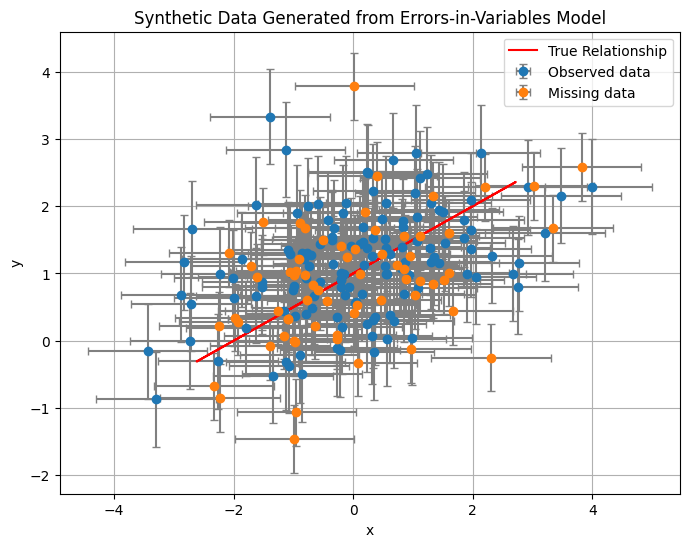

In [61]:
plt.figure(figsize=(8, 6))
plt.errorbar(x_obs, y_obs, xerr=params.sigma_x_sqrd, yerr=np.sqrt(params.sigma_y_sqrd+params.sigma_int_sqrd), fmt='o', ecolor='gray', capsize=3, label='Observed data')
plt.errorbar(x_miss, y_miss, xerr=params.sigma_x_sqrd, yerr=np.sqrt(params.sigma_y_sqrd), fmt='o', ecolor='gray', capsize=3, label='Missing data')
plt.xlabel('x')
plt.ylabel('y')
plt.title('Synthetic Data Generated from Errors-in-Variables Model')
plt.grid(True)
plt.plot(x_true, y_true_wo_int_dip, label='True Relationship', color='red')
plt.legend()
plt.show()

In [62]:
# Number of iterations for Gibbs sampler
num_iterations = 20000

samples = init_arrays(num_iterations,params)
# Initial values
x_miss_init = np.random.normal(loc=0, scale=np.std(np.std(y_obs)/2+params.sigma_y_sqrd), size=params.N - N_obs)
vars = {
    "theta_0": 0.0,
    "theta_1": 0.0,
    "x0": np.mean(x_obs),
    "Rx2": np.var(x_obs),
    "x_i": np.concatenate([x_obs, x_miss]),
    "y_i": np.concatenate([x_obs, x_miss]),
    "sigma_int_sqrd": np.std(y_obs)/2,
    "N_obs": N_obs,
    "N": params.N,
    "x_obs": x_obs,
    "y_obs": y_obs,
    "x_miss": x_miss,
    "y_miss": y_miss
}

# Start Gibbs sampling
for t in range(num_iterations):
    # Step 1: Sample x_i, x_j
    vars["x_i"][:vars["N_obs"]] = sample_x_i(vars, params)
    vars["x_i"][vars["N_obs"]:] = sample_x_j(vars, params)
    # Step 2: Sample y_i
    vars["y_i"][:vars["N_obs"]] = sample_y_i(vars, params)
    vars["y_i"][vars["N_obs"]:] = sample_y_j(vars, params)
    # Sample y_miss
    vars["y_miss"] = sample_y_miss(vars, params)
    # Step 3: Sample theta_0 and theta_1 jointly
    vars["theta_0"], vars["theta_1"] = sample_theta(vars, params)
    # Step 4: Sample x0
    vars["x0"] = sample_x0(vars, params)
    # Step 5: Sample Rx^2
    vars["Rx2"] = sample_Rx2(vars, params)
    #print("Rx2",vars["Rx2"])
    # Step 6: Sample sigma_int_sqrd
    vars["sigma_int_sqrd"] = sample_sigma_int_sqrd(vars, params)
    
    for key in samples.keys():
        samples[key][t] = vars[key]
    
    if t % 500 == 0:
        print(f"Iteration {t} completed.")

# Convert Rx^2 samples to Rx samples
Rx_samples = np.sqrt(samples["Rx2"])
samples["Rx"] = Rx_samples
# Convert sigma_int_sqrd_sqrd^2 samples to sigma_int_sqrd_sqrd samples
sigma_int_sqrd_samples = np.sqrt(samples["sigma_int_sqrd"])
samples["sigma_int"] = sigma_int_sqrd_samples

# Discard burn-in samples
burn_in = 1000
for key in samples:
    samples[key] = samples[key][burn_in:]


Iteration 0 completed.
Iteration 500 completed.
Iteration 1000 completed.
Iteration 1500 completed.
Iteration 2000 completed.
Iteration 2500 completed.
Iteration 3000 completed.
Iteration 3500 completed.
Iteration 4000 completed.
Iteration 4500 completed.
Iteration 5000 completed.
Iteration 5500 completed.
Iteration 6000 completed.
Iteration 6500 completed.
Iteration 7000 completed.
Iteration 7500 completed.
Iteration 8000 completed.
Iteration 8500 completed.
Iteration 9000 completed.
Iteration 9500 completed.
Iteration 10000 completed.
Iteration 10500 completed.
Iteration 11000 completed.
Iteration 11500 completed.
Iteration 12000 completed.
Iteration 12500 completed.
Iteration 13000 completed.
Iteration 13500 completed.
Iteration 14000 completed.
Iteration 14500 completed.
Iteration 15000 completed.
Iteration 15500 completed.
Iteration 16000 completed.
Iteration 16500 completed.
Iteration 17000 completed.
Iteration 17500 completed.
Iteration 18000 completed.
Iteration 18500 completed

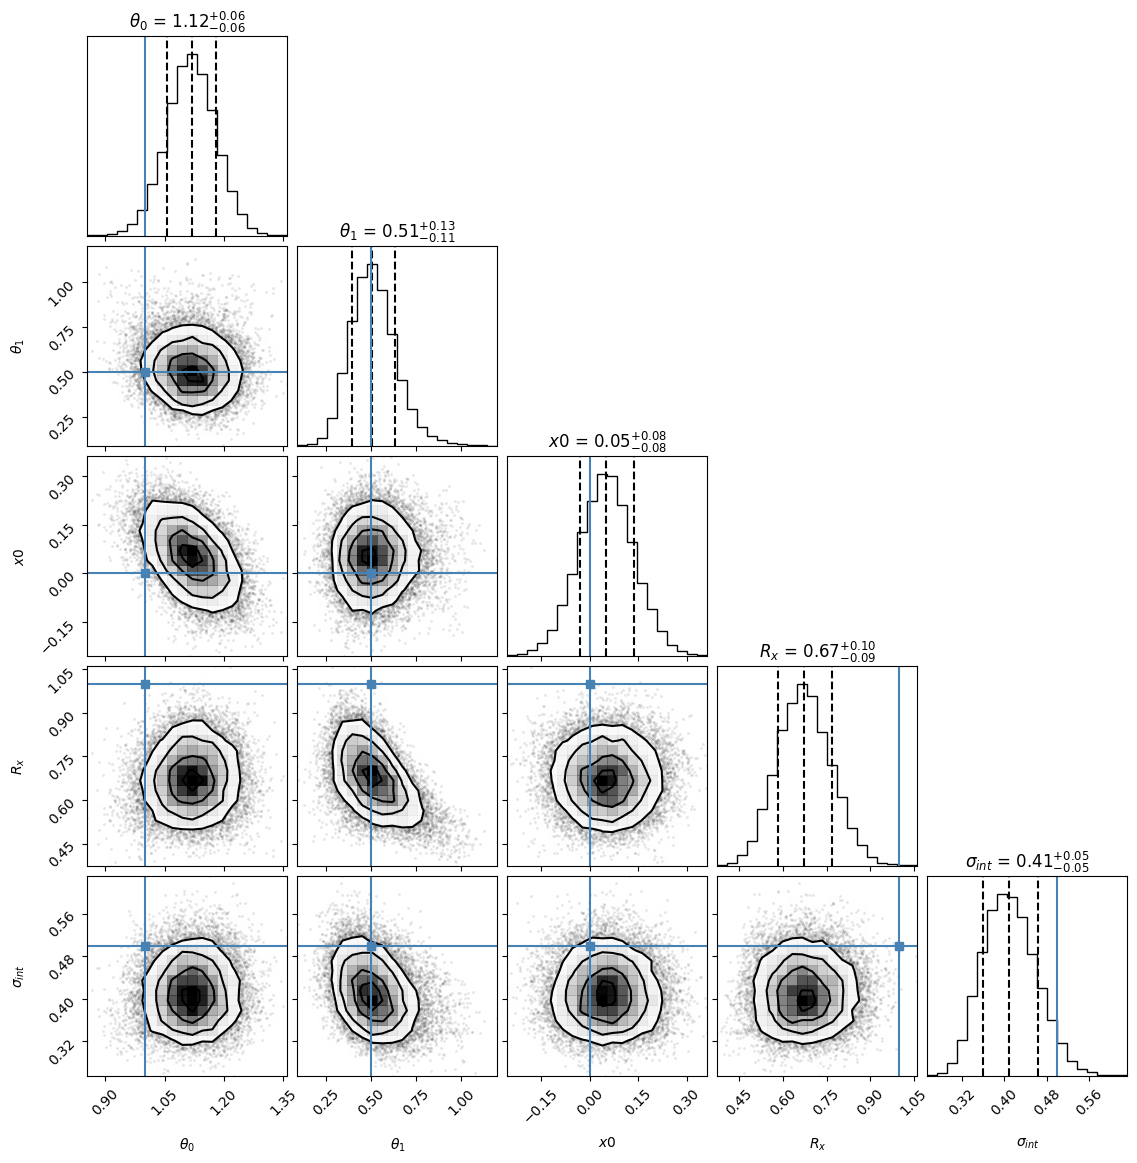

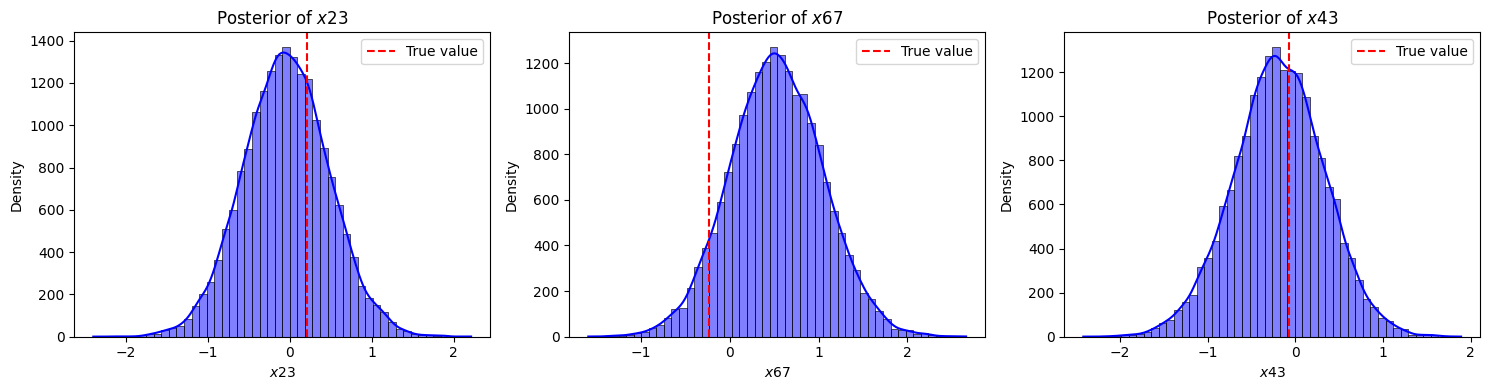

In [63]:
corner_plot(samples, params)
plot_marginal(samples, x_true)